In [2]:
from mesa import Agent, Model
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import graph_init
import pandas as pd
import station as st

import network_example as ne
import numpy as np
import pathfinding as pf
import graph_functions as gf
import matplotlib.pyplot as plt
import particle_swarm as ps
import model as m
import commuter as c
import bike_dist_hist as hist
import bike_dist_anim as anim

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


In [3]:
# test the model with 5 agents and full bike capacity

bike_distribution = {
    0:10,
    1:9,
    2:8,
    3:7
}

model = m.MyModel(100, seed=2, G=ne.basic_graph(capacity=10)[0], bike_init=bike_distribution)
for i in range(1000):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
pd.reset_option('display.max_rows', None)
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures']]

# print the 1000 index



Distance_Left  Position  Intermediate_Node  Destination  \
Step AgentID                                                            
0    1                120.0         4                  5            5   
     2                120.0         4                  5            5   
     3                 50.0         4                  0            7   
     4                 50.0         6                  2            4   
     5                 50.0         5                  1            6   
...                     ...       ...                ...          ...   
1000 96                25.0         1                  5            5   
     97                27.0         7                  3            5   
     98                41.0         7                  6            6   
     99                 7.0         4                  0            6   
     100               36.0         2                  6            6   

                       All Station Capacity  Biking  Park Failures  
Step AgentID                                                        
0    1        [0:{10}, 1:{9}, 2:{8}, 3:{7}]   False              0  
     2        [0:{10}, 1:{9}, 2:{8}, 3:{7}]   False              0  
     3        [0:{10}, 1:{9}, 2:{8}, 3:{7}]   False              0  
     4        [0:{10}, 1:{9}, 2:{8}, 3:{7}]   False              0  
     5        [0:{10}, 1:{9}, 2:{8}, 3:{7}]   False              0  
...                                     ...     ...            ...  
1000 96        [0:{8}, 1:{6}, 2:{7}, 3:{5}]   False              0  
     97        [0:{8}, 1:{6}, 2:{7}, 3:{5}]   False              0  
     98        [0:{8}, 1:{6}, 2:{7}, 3:{5}]   False              1  
     99        [0:{8}, 1:{6}, 2:{7}, 3:{5}]   False              1  
     100       [0:{8}, 1:{6}, 2:{7}, 3:{5}]   False              0  

[100100 rows x 7 columns]

Station 0 has 3 bikes
Station 1 has 3 bikes
Station 2 has 3 bikes
Station 3 has 3 bikes


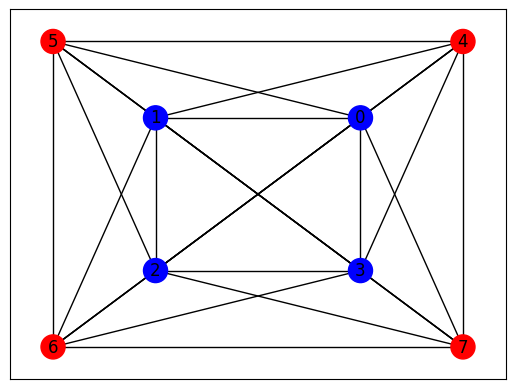

In [4]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}}


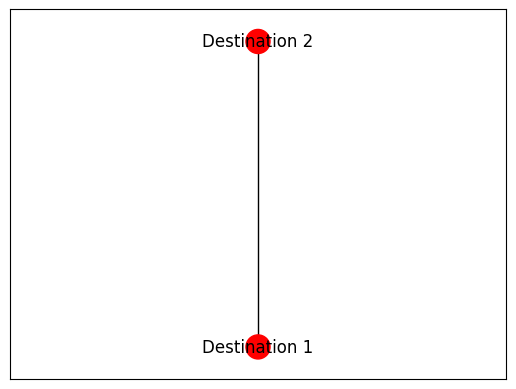

In [5]:
destinations_coords = [
    (0, -4.5), #McCombs
    (0, 4.5) #Target
]

G,s,d = gf.create_graph_from_coordinates([], destinations_coords)
#print(s)
#print(d)

pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5]}, node_color = colors, with_labels=True)



In [6]:
destinations = [i for i in G.nodes if G.nodes[i]['type'] == 'destination']

#destinationcoords = [(pos[i][0], pos[i][1]) for i in destinations]
destinationcoords = [(0, -4.5), (0, 4.5)]
G,s,d = gf.create_graph_from_coordinates([], destinationcoords)
citymap = [(-6,-6), (6,6)] + destinationcoords
w = [0.5, 0.5]
def fitness(coordinatelist):
    destinations = coordinatelist["destination"]
    stations = coordinatelist["station"]
    G, s, d, = gf.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(20, seed=1, G=G, weights = w)
    for i in range(100):
        model.step()
    return model.walking_average()

print(fitness({"destination": destinationcoords, "station": destinationcoords}))

optimizer = ps.PSO(citymap, fitness, 0.3,1.2,1.5)
bestpos, bestfit = optimizer.optimize_genetic(20, 2, 50, mutation_rate = .9, alpha = 0.3)
print(bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
print(stations)
G, s, d, = gf.create_graph_from_coordinates(stations, destinationcoords)

-3.1


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -1.0
Iteration 10: Best fitness: -1.3
Iteration 20: Best fitness: -1.9
Iteration 30: Best fitness: -1.9
Iteration 40: Best fitness: -2.5
-2.5
[(0.02461786956892542, -4.51308087151659), (0.24163068583116426, 4.406871496718067)]


In [16]:
model = m.MyModel(20, seed=1 , G=G, weights = w)
for i in range(100):
    model.step()

In [9]:
agent_data = model.datacollector.get_agent_vars_dataframe()
pd.set_option('display.max_rows', None)
agent_data = agent_data.xs(11, level = "AgentID")
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures', 'Trips']]
nx.adjacency_matrix(model.grid.G).todense()

/tmp/ipykernel_138857/2306864682.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(model.grid.G).todense()


matrix([[0.        , 8.92259182, 0.02787739, 9.01311449],
        [8.92259182, 0.        , 8.91014844, 0.25895619],
        [0.02787739, 8.91014844, 0.        , 9.        ],
        [9.01311449, 0.25895619, 9.        , 0.        ]])

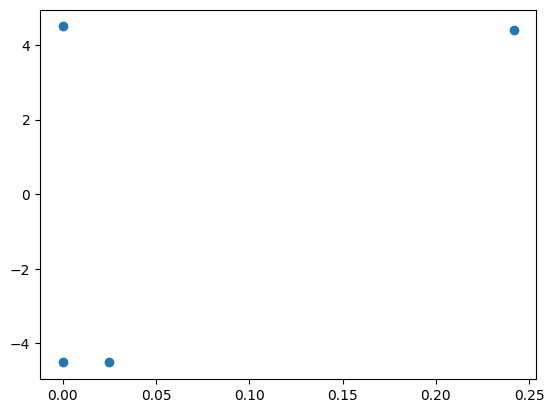

In [10]:
x = [i[0] for i in stations] + [i[0] for i in destinationcoords]
y = [i[1] for i in stations] + [i[1] for i in destinationcoords]
plt.scatter(x,y)